# SADs, lifespans and fates

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import os, scipy
import warnings
import collections as col
import pandas as pd
import seaborn as sns
from numpy import exp
from matplotlib import rc
from scipy import stats
from heapq import nsmallest
from sklearn.linear_model import LinearRegression
warnings.simplefilter('ignore')
plt.rcParams['mathtext.fontset'] = 'cm'

from matplotlib.transforms import Bbox
from itertools import repeat
from sklearn.metrics import r2_score
from matplotlib.offsetbox import AnchoredText
from random import seed, random, randint
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import Rectangle
from scipy.stats import skew,kurtosis
import probscale
from matplotlib.lines import Line2D

In [2]:
flatten = lambda t: [item for sublist in t for item in sublist]

In [3]:
font = {'family':'sans-serif','weight':'regular', 'style':'normal','size':18,'sans-serif':['Helvetica'] }
rc('font', **font)
rc('text', usetex=True) 
plt.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]
plt.rcParams['legend.title_fontsize'] = 18

gen=2000; TT=np.linspace(2,gen,int(gen-1),dtype=int); runs=50
labels = ['uncoupled', 's_175', 's_125', 's_075','s_025']
labels2 = [r'$NI$',r'$\sigma_w=0.175$',r'$\sigma_w=0.125$', r'$\sigma_w=0.075$',r'$\sigma_w=0.025$']
labels3 = [r'$NI$',r'$0.175$',r'$0.125$', r'$0.075$',r'$0.025$']
colorlist=['r','m','tab:orange','g','b']

case=[x for x in labels]
pielabels= 'Branch', 'Ext', 'Hyb', 'Pers'
clist = ['#51A3A3','#7570b3','#75485E','gray']

In [4]:
Tcut = 1000

ab_all = [[0]]*len(case); age_all = [[0]]*len(case); exp_all = [[0]]*len(case); type_all = [[0]]*len(case)
ab0 = [[0]]*len(case) #size of the species when they emerge

#type: 1 - intermediary; 2 - extinct; 3 - hybrid; 4 - living

for c in range(len(case)):
    path = "./"+case[c]
    ab_case=[]; age_case=[]; exp_case=[]; type_case=[]; ab0_case=[]
    for ii in range(runs):
        counter=str(ii+1).zfill(2)
        arr_txt = path+'/'+[x for x in os.listdir(path) if x.startswith("run_"+counter)][-1]
        y = [x for x in os.listdir("./"+arr_txt) if x.endswith("ext-sizes.dat")][0]
        inp = open (arr_txt+'/'+y)
        x_time=[]; x_size=[]
        y_time=[]; y_size=[]
        for line in inp.readlines()[1:]:
            p=line.split()
            aux1=int(p[1]); aux2=int(p[2])
            if(aux2==-1.0):
                x_size.append(int(p[0]))
                x_time.append(gen-int(p[1]))
            elif(aux2!=0):
                y_size.append(int(p[0]))
                y_time.append(gen-int(p[1]))
        inp.close()
        
        y = [x for x in os.listdir("./"+arr_txt) if x.endswith("global_abundances.dat")][0]
        with open(arr_txt+'/'+y,"r") as f:
            data = f.readlines()[1:gen]
        p=[0]*len(data)
        for i in range(len(data)):
            paux=data[i].split()
            p[i] = [int(jj) for jj in paux]    
        sp_full = [[] for i in range(len(p[-1]))]
        sp_aux = [[] for i in range(len(p[-1]))]
        t_sp_aux = np.zeros(len(sp_full), dtype=int)
        
        par=[0]*len(p[-1])
        y = [x for x in os.listdir("./"+arr_txt) if x.endswith("global_parents.dat")][0]
        with open(arr_txt+'/'+y,"r") as f:
            data = f.readlines()[1:gen]
        q=[0]*len(data)
        for i in range(len(data)):
            qaux=data[i].split()
            q[i] = [int(jj) for jj in qaux]
        par[0]=-1
        j=1
        for i in range(len(q)):
            while(j < len(q[i])):
                par[j]=q[i][j]-1
                j+=1
                
        for i in range(len(p)):
            for j in range(len(p[i])):
                sp_full[j].append(p[i][j])
        index_liv = [i for i, x in enumerate(p[-1]) if x != 0]
        
        for i in range(len(sp_full)):
            vaux = [x for x in sp_full[i] if x != 0]
            sp_aux[i]=vaux
            t_sp_aux[i]=len(sp_aux[i])
#         sp_aux = np.array(sp_aux)

        index_ext =[]
        for i in range(len(x_time)):
            tf = x_time[i]
            sf = x_size[i]
            for j in range(len(p[tf-2])):
                paux=p[tf-2][j]
                if(paux == sf):
                    if(p[tf-1][j] == 0 and j not in par):
                        if(j in index_ext): continue
                        else: col = j; index_ext.append(col); break
        t_ext_aux = np.take(t_sp_aux,index_ext)
        ext_aux = np.take(sp_aux,index_ext)                                         
            
        index_hyb=[]
        for i in range(len(y_time)):
            tf = y_time[i]
            sf = y_size[i]
            for j in range(len(p[tf-2])):
                paux=p[tf-2][j]
                if(paux == sf):
                    if(p[tf-1][j] == 0 and j not in par):
                        if(j in index_hyb): continue
                        else: col = j; index_hyb.append(col); break
        t_hyb_aux = np.take(t_sp_aux,index_hyb)
        hyb_aux = np.take(sp_aux,index_hyb)
            
        t_liv_aux = np.take(t_sp_aux,index_liv)
        liv_aux = np.take(sp_aux,index_liv)

        vaux = index_ext + index_hyb + index_liv
        index_int = [x for x in list(range(len(p[-1]))) if x not in vaux]
        t_int_aux = np.take(t_sp_aux,index_int)
        int_aux = np.take(sp_aux,index_int)
        
        # All abundances, ages and expectancies at T=Tcut
        cut = [x for x, x in enumerate(p[Tcut-2]) if x != 0] # abundance at Tcut
        indcut = [i for i, x in enumerate(p[Tcut-2]) if x != 0] # colum numbers of the species extant at Tcut 
        ages = [(Tcut - (gen - len(sp_full[x]) + 1)) for x, x in enumerate(indcut)]
        exps = [len(sp_aux[indcut[x]]) - ages[x] for x in range(len(ages)) ]
        ab_case.append(cut)
        age_case.append(ages)
        exp_case.append(exps)
        
        # type: 1 - intermediary; 2 - extinct; 3 - hybrid; 4 - living
        for x in range(len(cut)):
            if indcut[x] in index_int: tipo = 1
            elif indcut[x] in index_ext: tipo = 2
            elif indcut[x] in index_hyb: tipo = 3
            else: tipo = 4
            type_case.append(tipo)

        # Size when they emerged
        for x in range(len(cut)):
            ab0_case.append(sp_full[indcut[x]][0])
            
    ab_all[c] = flatten(ab_case)
    age_all[c] = flatten(age_case)
    exp_all[c] = flatten(exp_case)
    type_all[c] = type_case
    ab0[c] = ab0_case
    
    # Selecting the most and least abundant
    d = {'abundance': ab_all[c], 'age': age_all[c], 'expectancy': exp_all[c], 'tipe': type_all[c], 'size0': ab0[c]}
    df = pd.DataFrame(data=d)
    df.sort_values(by=['abundance'], inplace=True)

t_all = [[0]]*4
for i in range(4):
    t_all[i] = [type_all[c].count(i+1)/len(type_all[c]) for c in range(len(case))]

In [5]:
# Read 'global_abundances.dat' -- all times
ab_t = [[0]]*len(case) # First index = case; Second index = time
x_all = [[0]]*len(case); y_all = [[0]]*len(case);

for c in range(len(case)):
    path = "./"+case[c]
    ab_tt_list = [[] for i in range(len(TT))]
    for ii in range(runs):
        counter=str(ii+1).zfill(2)
        arr_txt = path+'/'+[x for x in os.listdir(path) if x.startswith("run_"+counter)][-1] 
        
        y = [x for x in os.listdir("./"+arr_txt) if x.endswith("global_abundances.dat")][0]
        with open(arr_txt+'/'+y,"r") as f:
            data = f.readlines()[1:]
        p=[0]*len(data) # p has all the lines (T lines)
        for i in range(len(data)):
            p[i]=data[i].split()
        ab_tt_aux = [[] for i in range(len(data))] # ab_tt_aux records abundances in time -- read the lines -- len(data) = len(TT)
        for i in range(len(p)):
            vaux1=[]
            for j in range(len(p[i])):
                vaux1.append(int(p[i][j]))
            ab_tt_aux[i] = [x for x in vaux1 if x != 0]
            ab_tt_list[i] = np.concatenate((ab_tt_list[i],ab_tt_aux[i]),axis=0)
                
    ab_t[c] = ab_tt_list
    
t = Tcut
for c in range(len(case)):
    y_all[c], x_all[c] = np.unique(ab_t[c][t-2], return_counts=True)

In [6]:
# Separate species in the bins
xind=11; bins=[[0]]*xind; ii=0
xplot=np.linspace(0,xind-1,xind)
major_ticks=[xplot[jj]+0.5 for jj in range(xind)]

while (ii < xind):
    aux=[]
    for x in range(math.ceil(2**(ii-1/2)),math.ceil(2**(ii+1/2))):
        aux.append(x)       
    bins[ii]=aux
    ii+=1


lf = [[0]]*len(case)
for c in range(len(case)):
    lf[c] = np.sum([age_all[c],exp_all[c]],axis=0)

bins_lf=[[0]]*len(case);
for c in range(len(case)):
    aux2 = np.array([np.array(list) for _ in range(xind)])
    for jj in range(xind):
        range_min=min(bins[jj])
        range_max=max(bins[jj])      
        aux1 = [];
        for i in range(len(lf[c])):
            if(range_min<=ab_all[c][i]<=range_max):
                aux1.append(lf[c][i])
        aux2[jj]=aux1
    bins_lf[c]=aux2

    
bins_type=[[0]]*len(case); counter=[[0]]*len(case); 
abund_t=[0]*len(case);tipe=[0]*len(case);

for c in range(len(case)):
    d = {'abundance': ab_all[c], 'age': age_all[c], 'expectancy': exp_all[c], 'type': type_all[c], 'size0': ab0[c]}
    df = pd.DataFrame(data=d)
    df.sort_values(by=['type'], inplace=True)
    abund_t[c]=df["abundance"].to_list()
    tipe[c]=df["type"].to_list()
    counter[c]=np.linspace(1,len(tipe[c]),len(tipe[c]))
    

    aux2 = np.array([np.array(list) for _ in range(xind)])
    aux3 = np.array([np.array(list) for _ in range(xind)])
    for jj in range(xind):
        range_min=min(bins[jj])
        range_max=max(bins[jj])      
        aux1 = [];
        for i in range(len(abund_t[c])):
            if(range_min<=abund_t[c][i]<=range_max):
                aux1.append(tipe[c][i])
        aux2[jj]=aux1
        aux3[jj]=np.linspace(1,len(aux1),len(aux1))
    bins_type[c]=aux2 
    counter[c]=aux3

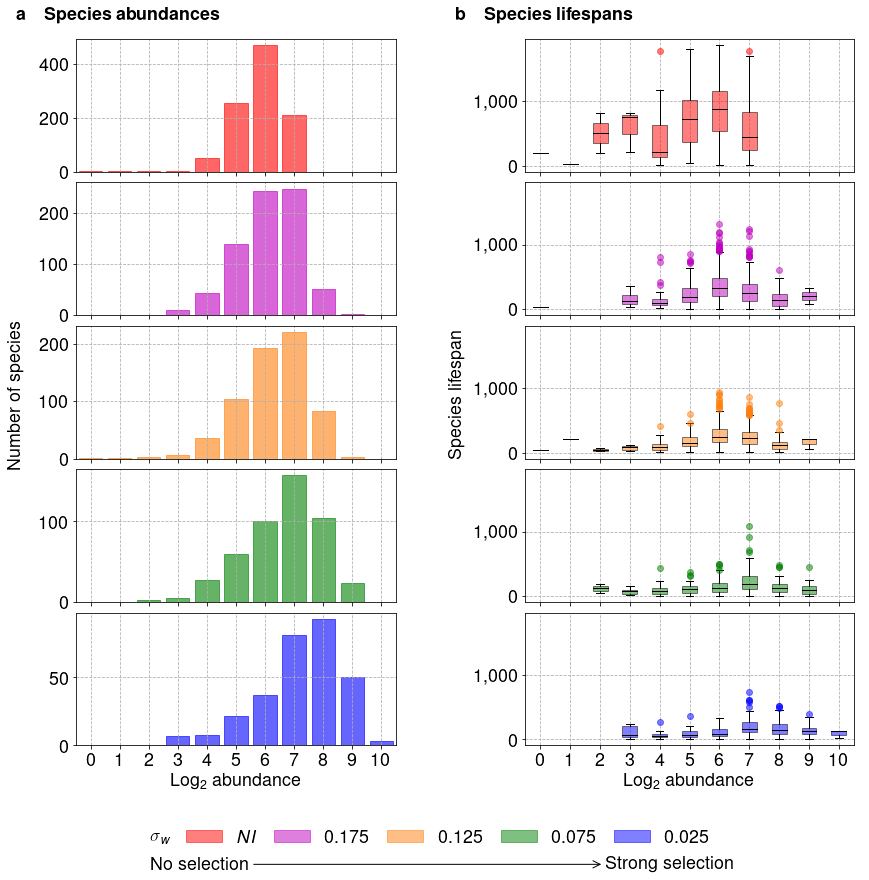

In [7]:
plt.rcParams.update(  {'figure.figsize': (12,13)})

xind=11
dfit=[[0] * xind for i in range(len(case))]
plabel=[int(2**(xplot[i]-1)) for i in range(len(xplot))]

fig = plt.figure(constrained_layout=False)
gs1 = fig.add_gridspec(5,1, left=0.07, right=0.44, hspace=0.08) #wspace=0.05
gs2 = fig.add_gridspec(5,1,left=0.59, right=0.97, hspace=0.08)
gs3 = fig.add_gridspec(1,1,left=0.05, right=0.98,top=0.01, bottom=-0.01)

ax1=[gs1[x] for x in range(len(case))]
ax2=[gs2[x] for x in range(len(case))]

ax1[0] = fig.add_subplot(gs1[0])
ax2[0] = fig.add_subplot(gs2[0])
for c in range(1,len(case)):
    ax1[c] = fig.add_subplot(gs1[c],sharex=ax1[0])
    ax2[c] = fig.add_subplot(gs2[c],sharex=ax2[0],sharey=ax2[0])

box=[];
for c in range(len(case)):
    counts=x_all[c].tolist()
    values=y_all[c].tolist()
    ii=0
    while (ii < xind):
        for x in range(math.ceil(2**(ii-1/2)),math.ceil(2**(ii+1/2))):
            if(x in values): dfit[c][ii]+=counts[values.index(x)]
        ii+=1
    ax1[c].bar(xplot, dfit[c], facecolor=colorlist[c],align='center',alpha=0.6,edgecolor = colorlist[c],label=labels2[c])
    ax1[c].set_xticks(xplot)
    ax1[c].set_xticklabels(['{:,}'.format(int(x)) for x in xplot])
    ax1[c].grid(linestyle='--')
    ax1[c].set_xlim([-0.5,10.5])
    box.append(mpatches.Patch(color=colorlist[c],alpha=0.5,edgecolor = colorlist[c],label=labels3[c]))
    if (c < (len(case)-1)): plt.setp(ax1[c].get_xticklabels(), visible=False)
    data=[]
    for jj in range(xind):
        data.append(bins_lf[c][jj])
#         for ii in range(len(bins_lf[c][jj])):
#             ax2[c].scatter(xplot[jj],bins_lf[c][jj][ii],color=colorlist[c])
    
    ax2[c].boxplot(data, positions = xplot, vert=True, patch_artist=True, showfliers=True, #showmeans=True,
                   boxprops=dict(facecolor=colorlist[c], color='k',alpha=0.5),
                   capprops=dict(color='k'),
                   whiskerprops=dict(color='k'),
                   flierprops=dict(color=colorlist[c], markeredgecolor=colorlist[c],markerfacecolor=colorlist[c],alpha=0.5),
                   medianprops=dict(color='k'),
                   )
    ax2[c].set_xticks(xplot)
    ax2[c].grid(linestyle='--')
    ax2[c].set_xlim([-0.5,10.5])
    ax2[c].set_yticklabels(['{:,}'.format(int(xx)) for xx in ax2[c].get_yticks().tolist()])
    ax2[c].set_xticklabels(['{:}'.format(int(xx)) for xx in ax2[c].get_xticks().tolist()])
    if (c < (len(case)-1)): plt.setp(ax2[c].get_xticklabels(), visible=False)


ax1[c].set_xlabel('Log$_2$ abundance')
ax2[c].set_xlabel('Log$_2$ abundance')

fig.text(0, 0.9,  r"$\bf{a \quad Species \: abundances}$ ")
fig.text(0, 0.5, 'Number of species', ha='center', va='center', rotation='vertical')
fig.text(0.51, 0.9, r"$\bf{b \quad Species \: lifespans}$ ")
fig.text(0.51,0.5, 'Species lifespan', ha='center', va='center', rotation='vertical')

fig.text(0.155, 0.023,  r"$\sigma_w$ ")

ax = fig.add_subplot(gs3[0])
ax.axis('off')
an1 = ax.annotate("No selection", xy=(0.115, 0.40), va="center", ha="left")
an2 = ax.annotate("Strong selection", xy=(0.24, 0.40), xytext=(0.84, 0.40), va="center", ha="right",arrowprops=dict(arrowstyle="<-"))

legend=fig.legend(handles=box, loc="lower center", bbox_to_anchor=(0.5, 0),ncol=5, frameon=False,columnspacing=1) #title=r'$\sigma_w$',
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout()
plt.show()

# fig.savefig('./Figuras/Fig3.pdf',transparent=True,bbox_inches='tight')

In [8]:
def ax_stacked_bar(data, series_labels, category_labels=None, y_label=None, colors=None, grid=True):
    ny = len(data[0])
    ind = list(range(ny))
    axes = []
    cum_size = np.zeros(ny)
    data = np.array(data)
    
    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(ax3[c].bar(ind, row_data, bottom=cum_size, color=color))
        cum_size += row_data
    if (c < (len(case)-1)): plt.setp(ax3[c].get_xticklabels(), visible=False)
    if (c == len(case)-1): ax3[c].set_xlabel('Log$_2$ abundance')
        
    if category_labels:
        ax3[c].set_xticks(category_labels)
        ax3[c].set_xticklabels(['{:,}'.format(int(x)) for x in category_labels])
        ax3[c].set_xlim([-0.5,10.5])
    if grid:
        plt.grid()
        ax3[c].grid(which='both', axis='both',linestyle='--')    
    
    legend_elements = []
    percentage = [f'{s:0.1f}%' for s in [t_all[i][c]*100 for i in range(len(pielabels))]]
    for i in range(len(pielabels)): legend_elements.append(Line2D([0],[0], lw=4, label=percentage[i], color=colors[i]))
#     for i in range(len(pielabels)): legend_elements.append(mpatches.Patch(color=colors[i], label=percentage[i]+"%%")) 
    ax3[c].legend(handles=legend_elements, loc=2, fontsize=16,title=labels2[c],title_fontsize=16,framealpha=1)

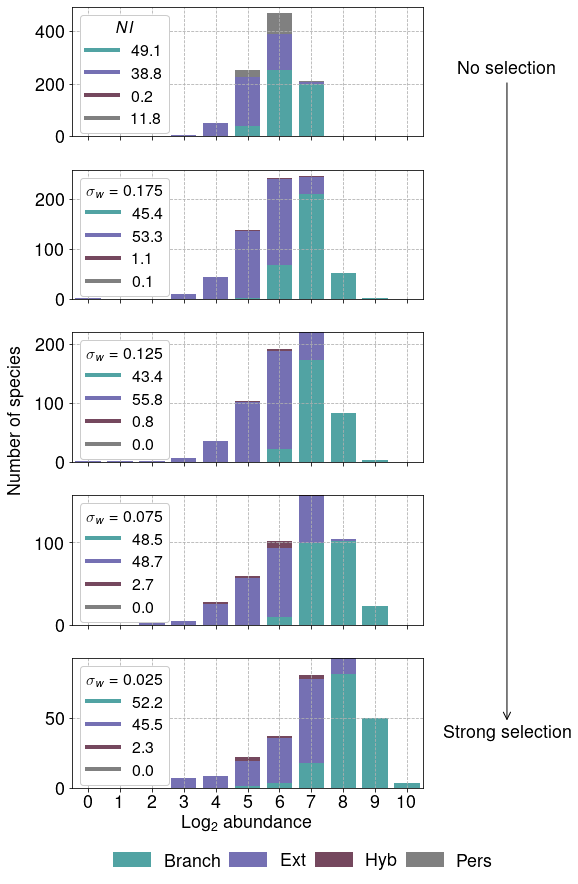

In [9]:
plt.rcParams.update(  {'figure.figsize': (8,12)})

pielabels= 'Branch', 'Ext', 'Hyb', 'Pers'
rates = ['Sp', 'Ext', 'Hyb']
clist = ['#51A3A3','#7570b3','#75485E','gray']
series_labels = pielabels
category_labels = list(xplot)
aux2=[0]*4

fig = plt.figure(constrained_layout=False)
gs3 = fig.add_gridspec(5,2,width_ratios=[0.85,0.15])

ax3=[gs3[x,0] for x in range(len(case))]
ax3[0] = fig.add_subplot(gs3[0,0])
for c in range(1,len(case)):
    ax3[c] = fig.add_subplot(gs3[c,0])

for c in range(len(case)):
    for ii in range(1,5):
        aux1=[]
        for jj in range(xind):
            aux1.append((bins_type[c][jj]).count(ii))
        aux2[ii-1]=aux1
    data=[aux2[0],aux2[1],aux2[2],aux2[3]]
    ax3[c]=ax_stacked_bar(data, series_labels, category_labels=category_labels, colors=clist)

fig.text(0,0.5, 'Number of species', ha='center', va='center', rotation='vertical')

ax=fig.add_subplot(gs3[:,1])
ax.axis('off')
an1 = ax.annotate("No selection", xy=(0.1, 0.92), va="center", ha="center")
an2 = ax.annotate("Strong selection", xy=(0.1, 0.905), xytext=(0.1, 0.07), va="center", ha="center",arrowprops=dict(arrowstyle="<-"))

box2=[]
for ii in range(4): box2.append(mpatches.Patch(color=clist[ii],alpha=1,edgecolor = clist[ii],label=pielabels[ii],lw=2))  
legend2=fig.legend(handles=box2, loc ="lower center", ncol=4,bbox_to_anchor=(0.5, -0.04), frameon=False,columnspacing=0.5)
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout()
plt.show()
# fig.savefig('./Figuras/Fig4.pdf',transparent=True,bbox_inches='tight')